In [33]:
SF = 100

In [34]:
from psutil import *
core=cpu_count()
core

8

In [35]:
Table_Path = '/lakehouse/default/Tables'
Files_Path = '/lakehouse/default/Files'

In [36]:
import duckdb
import pathlib
from deltalake import convert_to_deltalake
if not pathlib.Path(f'{Table_Path}/CH{SF:02d}').exists():
  if not pathlib.Path(f'{Files_Path}/tpch_{SF:02d}.duckdb').exists():
    print('generate new database')
    pathlib.Path(f'{Files_Path}').mkdir(parents=True, exist_ok=True)
    con=duckdb.connect(f'{Files_Path}/tpch_{SF:02d}.duckdb')
    con.sql(f"CALL dbgen(sf={SF}) ")
  else:
     con=duckdb.connect(f'{Files_Path}/tpch_{SF:02d}.duckdb',read_only=1)
     print('DB exist')
  for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part']:
      pathlib.Path(f'{Table_Path}/CH{SF:02d}/{tbl}').mkdir(parents=True, exist_ok=True)
      con.sql(f"""  COPY (SELECT * FROM {tbl}) TO '{Table_Path}/CH{SF:02d}/{tbl}' (FORMAT PARQUET,PER_THREAD_OUTPUT TRUE) """)
      convert_to_deltalake(f'{Table_Path}/CH{SF:02d}/{tbl}',storage_options={"allow_unsafe_rename":"true"})
  con.close()
else:
  print("Already Generated")

Already Generated


# SQL Query

In [37]:
# @title
sql=(f'''
SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;


SELECT
    --Query02
    s_acctbal,
    s_name,
    n_name,
    p_partkey,
    p_mfgr,
    s_address,
    s_phone,
    s_comment
FROM
    part,
    supplier,
    partsupp,
    nation,
    region
WHERE
    p_partkey = ps_partkey
    AND s_suppkey = ps_suppkey
    AND p_size = 15
    AND p_type LIKE '%BRASS'
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'EUROPE'
    AND ps_supplycost = (
        SELECT
            MIN(ps_supplycost)
        FROM
            partsupp,
            supplier,
            nation,
            region
        WHERE
            p_partkey = ps_partkey
            AND s_suppkey = ps_suppkey
            AND s_nationkey = n_nationkey
            AND n_regionkey = r_regionkey
            AND r_name = 'EUROPE'
    )
ORDER BY
    s_acctbal DESC,
    n_name,
    s_name,
    p_partkey
LIMIT
    100;







SELECT
    --Query03
    l_orderkey,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    o_orderdate,
    o_shippriority
FROM
    customer,
    orders,
    lineitem
WHERE
    c_mktsegment = 'BUILDING'
    AND c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate < CAST('1995-03-15' AS date)
    AND l_shipdate > CAST('1995-03-15' AS date)
GROUP BY
    l_orderkey,
    o_orderdate,
    o_shippriority
ORDER BY
    revenue DESC,
    o_orderdate
LIMIT
    10;








SELECT
    --Query04
    o_orderpriority,
    COUNT(*) AS order_count
FROM
    orders
WHERE
    o_orderdate >= CAST('1993-07-01' AS date)
    AND o_orderdate < CAST('1993-10-01' AS date)
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem
        WHERE
            l_orderkey = o_orderkey
            AND l_commitdate < l_receiptdate
    )
GROUP BY
    o_orderpriority
ORDER BY
    o_orderpriority;








SELECT
    --Query05
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    customer,
    orders,
    lineitem,
    supplier,
    nation,
    region
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND l_suppkey = s_suppkey
    AND c_nationkey = s_nationkey
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'ASIA'
    AND o_orderdate >= CAST('1994-01-01' AS date)
    AND o_orderdate < CAST('1995-01-01' AS date)
GROUP BY
    n_name
ORDER BY
    revenue DESC;







SELECT
    --Query06
    SUM(l_extendedprice * l_discount) AS revenue
FROM
    lineitem
WHERE
    l_shipdate >= CAST('1994-01-01' AS date)
    AND l_shipdate < CAST('1995-01-01' AS date)
    AND l_discount BETWEEN 0.05
    AND 0.07
    AND l_quantity < 24;







SELECT
    --Query07
    supp_nation,
    cust_nation,
    l_year,
    SUM(volume) AS revenue
FROM
    (
        SELECT
            n1.n_name AS supp_nation,
            n2.n_name AS cust_nation,
            EXTRACT(
                year
                FROM
                    l_shipdate
            ) AS l_year,
            l_extendedprice * (1 - l_discount) AS volume
        FROM
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2
        WHERE
            s_suppkey = l_suppkey
            AND o_orderkey = l_orderkey
            AND c_custkey = o_custkey
            AND s_nationkey = n1.n_nationkey
            AND c_nationkey = n2.n_nationkey
            AND (
                (
                    n1.n_name = 'FRANCE'
                    AND n2.n_name = 'GERMANY'
                )
                OR (
                    n1.n_name = 'GERMANY'
                    AND n2.n_name = 'FRANCE'
                )
            )
            AND l_shipdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
    ) AS shipping
GROUP BY
    supp_nation,
    cust_nation,
    l_year
ORDER BY
    supp_nation,
    cust_nation,
    l_year;







SELECT
    --Query08
    o_year,
    SUM(
        CASE
            WHEN nation = 'BRAZIL' THEN volume
            ELSE 0
        END
    ) / SUM(volume) AS mkt_share
FROM
    (
        SELECT
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) AS volume,
            n2.n_name AS nation
        FROM
            part,
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2,
            region
        WHERE
            p_partkey = l_partkey
            AND s_suppkey = l_suppkey
            AND l_orderkey = o_orderkey
            AND o_custkey = c_custkey
            AND c_nationkey = n1.n_nationkey
            AND n1.n_regionkey = r_regionkey
            AND r_name = 'AMERICA'
            AND s_nationkey = n2.n_nationkey
            AND o_orderdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
            AND p_type = 'ECONOMY ANODIZED STEEL'
    ) AS all_nations
GROUP BY
    o_year
ORDER BY
    o_year;










SELECT
    --Query09
    nation,
    o_year,
    SUM(amount) AS sum_profit
FROM
    (
        SELECT
            n_name AS nation,
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity AS amount
        FROM
            part,
            supplier,
            lineitem,
            partsupp,
            orders,
            nation
        WHERE
            s_suppkey = l_suppkey
            AND ps_suppkey = l_suppkey
            AND ps_partkey = l_partkey
            AND p_partkey = l_partkey
            AND o_orderkey = l_orderkey
            AND s_nationkey = n_nationkey
            AND p_name LIKE '%green%'
    ) AS profit
GROUP BY
    nation,
    o_year
ORDER BY
    nation,
    o_year DESC;








SELECT
    --Query10
    c_custkey,
    c_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    c_acctbal,
    n_name,
    c_address,
    c_phone,
    c_comment
FROM
    customer,
    orders,
    lineitem,
    nation
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate >= CAST('1993-10-01' AS date)
    AND o_orderdate < CAST('1994-01-01' AS date)
    AND l_returnflag = 'R'
    AND c_nationkey = n_nationkey
GROUP BY
    c_custkey,
    c_name,
    c_acctbal,
    c_phone,
    n_name,
    c_address,
    c_comment
ORDER BY
    revenue DESC
LIMIT
    20;







SELECT
    --Query11
    ps_partkey,
    SUM(ps_supplycost * ps_availqty) AS value
FROM
    partsupp,
    supplier,
    nation
WHERE
    ps_suppkey = s_suppkey
    AND s_nationkey = n_nationkey
    AND n_name = 'GERMANY'
GROUP BY
    ps_partkey
HAVING
    SUM(ps_supplycost * ps_availqty) > (
        SELECT
            SUM(ps_supplycost * ps_availqty) * (0.0001/{SF})
            -- SUM(ps_supplycost * ps_availqty) * 1
        FROM
            partsupp,
            supplier,
            nation
        WHERE
            ps_suppkey = s_suppkey
            AND s_nationkey = n_nationkey
            AND n_name = 'GERMANY'
    )
ORDER BY
    value DESC;








SELECT
    --Query12
    l_shipmode,
    SUM(
        CASE
            WHEN o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS high_line_count,
    SUM(
        CASE
            WHEN o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS low_line_count
FROM
    orders,
    lineitem
WHERE
    o_orderkey = l_orderkey
    AND l_shipmode IN ('MAIL', 'SHIP')
    AND l_commitdate < l_receiptdate
    AND l_shipdate < l_commitdate
    AND l_receiptdate >= CAST('1994-01-01' AS date)
    AND l_receiptdate < CAST('1995-01-01' AS date)
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;








SELECT
    --Query13
    c_count,
    COUNT(*) AS custdist
FROM
    (
        SELECT
            c_custkey,
            COUNT(o_orderkey) AS c_count
        FROM
            customer
            LEFT OUTER JOIN orders ON c_custkey = o_custkey
            AND o_comment NOT LIKE '%special%requests%'
        GROUP BY
            c_custkey
    ) AS c_orders
GROUP BY
    c_count
ORDER BY
    custdist DESC,
    c_count DESC;








SELECT
    --Query14
    100.00 * SUM(
        CASE
            WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
            ELSE 0
        END
    ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
FROM
    lineitem,
    part
WHERE
    l_partkey = p_partkey
    AND l_shipdate >= date '1995-09-01'
    AND l_shipdate < CAST('1995-10-01' AS date);








SELECT
    --Query15
    s_suppkey,
    s_name,
    s_address,
    s_phone,
    total_revenue
FROM
    supplier,
    (
        SELECT
            l_suppkey AS supplier_no,
            SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1996-01-01' AS date)
            AND l_shipdate < CAST('1996-04-01' AS date)
        GROUP BY
            l_suppkey
    ) revenue0
WHERE
    s_suppkey = supplier_no
    AND total_revenue = (
        SELECT
            MAX(total_revenue)
        FROM
            (
                SELECT
                    l_suppkey AS supplier_no,
                    SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    lineitem
                WHERE
                    l_shipdate >= CAST('1996-01-01' AS date)
                    AND l_shipdate < CAST('1996-04-01' AS date)
                GROUP BY
                    l_suppkey
            ) revenue1
    )
ORDER BY
    s_suppkey;








SELECT
    --Query16
    p_brand,
    p_type,
    p_size,
    COUNT(DISTINCT ps_suppkey) AS supplier_cnt
FROM
    partsupp,
    part
WHERE
    p_partkey = ps_partkey
    AND p_brand <> 'Brand#45'
    AND p_type NOT LIKE 'MEDIUM POLISHED%'
    AND p_size IN (
        49,
        14,
        23,
        45,
        19,
        3,
        36,
        9
    )
    AND ps_suppkey NOT IN (
        SELECT
            s_suppkey
        FROM
            supplier
        WHERE
            s_comment LIKE '%Customer%Complaints%'
    )
GROUP BY
    p_brand,
    p_type,
    p_size
ORDER BY
    supplier_cnt DESC,
    p_brand,
    p_type,
    p_size;








SELECT
    --Query17
    SUM(l_extendedprice) / 7.0 AS avg_yearly
FROM
    lineitem,
    part
WHERE
    p_partkey = l_partkey
    AND p_brand = 'Brand#23'
    AND p_container = 'MED BOX'
    AND l_quantity < (
        SELECT
            0.2 * AVG(l_quantity)
        FROM
            lineitem
        WHERE
            l_partkey = p_partkey
    );






SELECT
    --Query18
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice,
    SUM(l_quantity)
FROM
    customer,
    orders,
    lineitem
WHERE
    o_orderkey IN (
        SELECT
            l_orderkey
        FROM
            lineitem
        GROUP BY
            l_orderkey
        HAVING
            SUM(l_quantity) > 300
    )
    AND c_custkey = o_custkey
    AND o_orderkey = l_orderkey
GROUP BY
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice
ORDER BY
    o_totalprice DESC,
    o_orderdate
LIMIT
    100;





SELECT
    --Query19
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    lineitem,
    part
WHERE
    (
        p_partkey = l_partkey
        AND p_brand = 'Brand#12'
        AND p_container IN (
            'SM CASE',
            'SM BOX',
            'SM PACK',
            'SM PKG'
        )
        AND l_quantity >= 1
        AND l_quantity <= 1 + 10
        AND p_size BETWEEN 1
        AND 5
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#23'
        AND p_container IN (
            'MED BAG',
            'MED BOX',
            'MED PKG',
            'MED PACK'
        )
        AND l_quantity >= 10
        AND l_quantity <= 10 + 10
        AND p_size BETWEEN 1
        AND 10
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#34'
        AND p_container IN (
            'LG CASE',
            'LG BOX',
            'LG PACK',
            'LG PKG'
        )
        AND l_quantity >= 20
        AND l_quantity <= 20 + 10
        AND p_size BETWEEN 1
        AND 15
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    );






SELECT
    --Query20
    s_name,
    s_address
FROM
    supplier,
    nation
WHERE
    s_suppkey IN (
        SELECT
            ps_suppkey
        FROM
            partsupp
        WHERE
            ps_partkey IN (
                SELECT
                    p_partkey
                FROM
                    part
                WHERE
                    p_name LIKE 'forest%'
            )
            AND ps_availqty > (
                SELECT
                    0.5 * SUM(l_quantity)
                FROM
                    lineitem
                WHERE
                    l_partkey = ps_partkey
                    AND l_suppkey = ps_suppkey
                    AND l_shipdate >= CAST('1994-01-01' AS date)
                    AND l_shipdate < CAST('1995-01-01' AS date)
            )
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'CANADA'
ORDER BY
    s_name;






SELECT
    --Query21
    s_name,
    COUNT(*) AS numwait
FROM
    supplier,
    lineitem l1,
    orders,
    nation
WHERE
    s_suppkey = l1.l_suppkey
    AND o_orderkey = l1.l_orderkey
    AND o_orderstatus = 'F'
    AND l1.l_receiptdate > l1.l_commitdate
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem l2
        WHERE
            l2.l_orderkey = l1.l_orderkey
            AND l2.l_suppkey <> l1.l_suppkey
    )
    AND NOT EXISTS (
        SELECT
            *
        FROM
            lineitem l3
        WHERE
            l3.l_orderkey = l1.l_orderkey
            AND l3.l_suppkey <> l1.l_suppkey
            AND l3.l_receiptdate > l3.l_commitdate
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'SAUDI ARABIA'
GROUP BY
    s_name
ORDER BY
    numwait DESC,
    s_name
LIMIT
    100;






SELECT
    --Query22
    cntrycode,
    COUNT(*) AS numcust,
    SUM(c_acctbal) AS totacctbal
FROM
    (
        SELECT
            SUBSTRING(c_phone, 1, 2) AS cntrycode,
            c_acctbal
        FROM
            customer
        WHERE
            SUBSTRING(c_phone, 1, 2) IN (
                '13',
                '31',
                '23',
                '29',
                '30',
                '18',
                '17'
            )
            AND c_acctbal > (
                SELECT
                    AVG(c_acctbal)
                FROM
                    customer
                WHERE
                    c_acctbal > 0.00
                    AND SUBSTRING(c_phone, 1, 2) IN (
                        '13',
                        '31',
                        '23',
                        '29',
                        '30',
                        '18',
                        '17'
                    )
            )
            AND NOT EXISTS (
                SELECT
                    *
                FROM
                    orders
                WHERE
                    o_custkey = c_custkey
            )
    ) AS custsale
GROUP BY
    cntrycode
ORDER BY
    cntrycode;

''')

# Utility Function

In [38]:
%%time
import time
import pandas as pd
from deltalake.writer import write_deltalake
from datetime import datetime
pd.set_option('display.max_columns', 20)
def execute_query(engine, sql_script):
    df = pd.DataFrame(columns=['dur','query'])
    sql_arr = sql_script.split(";")
    for index, value in enumerate(sql_arr,start=1):
        if len(value.strip()) > 0:
            start = time.time()
            print('Query' + str(index))
            try :
             engine.sql(value).show()
             stop = time.time()
             duration = stop-start
            except  Exception as er:
              print(er)
              duration = float('nan')
            print(duration)
            row = {'dur': duration,'query':index}
            df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)
    return df

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
%%time
import duckdb
start = time.time()
con=duckdb.connect(f'/lakehouse/default/Files/tpch_{SF}.duckdb',read_only=True)
stop = time.time()
external_table_duration = stop-start
df=execute_query(con, sql)
df.at[0,'dur'] = df.at[0, 'dur'] + external_table_duration
df['Engine'] = 'native'
df['time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df['sf'] = SF
df['cpu'] = core
df['test'] = 'tpch'
con.close()
write_deltalake('/lakehouse/default/Tables/dbo/result', df,mode="append",engine ='rust',storage_options={"allow_unsafe_rename":"true"})  

In [40]:
%%time
import duckdb
start = time.time()
for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :            
 duckdb.sql(f''' CREATE or replace View  {tbl} AS SELECT * FROM delta_scan('{Table_Path}/CH{SF:02d}/{tbl}') ''')
stop = time.time()
external_table_duration = stop-start
df=execute_query(duckdb, sql)
df.at[0,'dur'] = df.at[0, 'dur'] + external_table_duration
df['Engine'] = 'delta'
df['time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df['sf'] = SF
df['cpu'] = core
df['test'] = 'tpch'
write_deltalake('/lakehouse/default/Tables/dbo/result', df,mode="append",engine ='rust',storage_options={"allow_unsafe_rename":"true"}) 

Query1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬──────────────┬───────────────┬───────────────────┬─────────────────────┬───────────────────────┬────────────────────┬────────────────────┬──────────────────────┬─────────────┐
│ l_returnflag │ l_linestatus │    sum_qty    │  sum_base_price   │   sum_disc_price    │      sum_charge       │      avg_qty       │     avg_price      │       avg_disc       │ count_order │
│   varchar    │   varchar    │ decimal(38,2) │   decimal(38,2)   │    decimal(38,4)    │     decimal(38,6)     │       double       │       double       │        double        │    int64    │
├──────────────┼──────────────┼───────────────┼───────────────────┼─────────────────────┼───────────────────────┼────────────────────┼────────────────────┼──────────────────────┼─────────────┤
│ A            │ F            │ 3775127758.00 │  5660776097194.45 │  5377736398183.9374 │  5592847429515.927026 │ 25.499370423275426 │  38236.11698430489 │ 0.050002243530929025 │   148047881 │
│ N            │ F            │   9

<timed exec>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬────────────────────┬────────────────┬───────────┬────────────────┬──────────────────────────────────────────┬─────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────┐
│   s_acctbal   │       s_name       │     n_name     │ p_partkey │     p_mfgr     │                s_address                 │     s_phone     │                                             s_comment                                              │
│ decimal(15,2) │      varchar       │    varchar     │   int64   │    varchar     │                 varchar                  │     varchar     │                                              varchar                                               │
├───────────────┼────────────────────┼────────────────┼───────────┼────────────────┼──────────────────────────────────────────┼─────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────┤
│       9999

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬───────────────┬─────────────┬────────────────┐
│ l_orderkey │    revenue    │ o_orderdate │ o_shippriority │
│   int64    │ decimal(38,4) │    date     │     int32      │
├────────────┼───────────────┼─────────────┼────────────────┤
│  249739810 │   492136.8537 │ 1995-02-28  │              0 │
│  165214338 │   485645.5293 │ 1995-03-09  │              0 │
│  507274210 │   485256.2467 │ 1995-03-10  │              0 │
│  202071367 │   474746.4068 │ 1995-03-12  │              0 │
│   37307463 │   474325.1938 │ 1995-02-06  │              0 │
│  461984355 │   468002.5274 │ 1995-03-13  │              0 │
│  100810368 │   467932.7645 │ 1995-02-28  │              0 │
│   74015523 │   467786.8027 │ 1995-03-14  │              0 │
│  402772582 │   463367.0665 │ 1995-03-10  │              0 │
│  367111712 │   462559.3977 │ 1995-03-01  │              0 │
├────────────┴───────────────┴─────────────┴────────────────┤
│ 10 rows                                         4 columns │
└───────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────┬─────────────┐
│ o_orderpriority │ order_count │
│     varchar     │    int64    │
├─────────────────┼─────────────┤
│ 1-URGENT        │     1051801 │
│ 2-HIGH          │     1051366 │
│ 3-MEDIUM        │     1051587 │
│ 4-NOT SPECIFIED │     1050950 │
│ 5-LOW           │     1051725 │
└─────────────────┴─────────────┘

8.716546297073364
Query5


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬─────────────────┐
│  n_name   │     revenue     │
│  varchar  │  decimal(38,4)  │
├───────────┼─────────────────┤
│ VIETNAM   │ 5310749966.8670 │
│ INDIA     │ 5296094837.7503 │
│ JAPAN     │ 5282184528.8254 │
│ CHINA     │ 5270934901.5602 │
│ INDONESIA │ 5270340980.4608 │
└───────────┴─────────────────┘

11.623889446258545
Query6


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┐
│     revenue      │
│  decimal(38,4)   │
├──────────────────┤
│ 12330426888.4637 │
└──────────────────┘

7.067480802536011
Query7


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬─────────────┬────────┬─────────────────┐
│ supp_nation │ cust_nation │ l_year │     revenue     │
│   varchar   │   varchar   │ int64  │  decimal(38,4)  │
├─────────────┼─────────────┼────────┼─────────────────┤
│ FRANCE      │ GERMANY     │   1995 │ 5296106289.7407 │
│ FRANCE      │ GERMANY     │   1996 │ 5313955237.5650 │
│ GERMANY     │ FRANCE      │   1995 │ 5286060012.2108 │
│ GERMANY     │ FRANCE      │   1996 │ 5324729138.8922 │
└─────────────┴─────────────┴────────┴─────────────────┘

13.297720193862915
Query8


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────┬──────────────────────┐
│ o_year │      mkt_share       │
│ int64  │        double        │
├────────┼──────────────────────┤
│   1995 │ 0.039535108776109315 │
│   1996 │  0.03897424492526502 │
└────────┴──────────────────────┘

13.993254899978638
Query9


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬────────┬─────────────────┐
│    nation     │ o_year │   sum_profit    │
│    varchar    │ int64  │  decimal(38,4)  │
├───────────────┼────────┼─────────────────┤
│ ALGERIA       │   1998 │ 2746388473.8032 │
│ ALGERIA       │   1997 │ 4705096214.1934 │
│ ALGERIA       │   1996 │ 4691101028.3880 │
│ ALGERIA       │   1995 │ 4692240612.2209 │
│ ALGERIA       │   1994 │ 4677512644.2049 │
│ ALGERIA       │   1993 │ 4684367583.8281 │
│ ALGERIA       │   1992 │ 4704266160.0314 │
│ ARGENTINA     │   1998 │ 2718513010.8517 │
│ ARGENTINA     │   1997 │ 4646318596.6846 │
│ ARGENTINA     │   1996 │ 4656102598.0412 │
│     ·         │     ·  │        ·        │
│     ·         │     ·  │        ·        │
│     ·         │     ·  │        ·        │
│ UNITED STATES │   1994 │ 4671044724.0807 │
│ UNITED STATES │   1993 │ 4680519402.4766 │
│ UNITED STATES │   1992 │ 4707714157.3208 │
│ VIETNAM       │   1998 │ 2741387136.2468 │
│ VIETNAM       │   1997 │ 4661928954.8541 │
│ VIETNAM 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬────────────────────┬───────────────┬───────────────┬────────────────┬──────────────────────────────────────────┬─────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ c_custkey │       c_name       │    revenue    │   c_acctbal   │     n_name     │                c_address                 │     c_phone     │                                                      c_comment                                                       │
│   int64   │      varchar       │ decimal(38,4) │ decimal(15,2) │    varchar     │                 varchar                  │     varchar     │                                                       varchar                                                        │
├───────────┼────────────────────┼───────────────┼───────────────┼────────────────┼──────────────────────────────────────────┼─────────────────┼────────────────────────────────────────────────────────────────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬───────────────┐
│ ps_partkey │     value     │
│   int64    │ decimal(38,2) │
├────────────┼───────────────┤
│   16036036 │   23649655.33 │
│   17367252 │   22489140.14 │
│    4374484 │   22044999.19 │
│   17187643 │   21691256.18 │
│    1508568 │   21613789.59 │
│   13194737 │   21608873.36 │
│    6053362 │   20740203.91 │
│   12321311 │   20406325.41 │
│   15560083 │   20401600.81 │
│    1985583 │   20348636.97 │
│       ·    │        ·      │
│       ·    │        ·      │
│       ·    │        ·      │
│    1623138 │   10724796.70 │
│    1725481 │   10724419.73 │
│    9775497 │   10724000.44 │
│   11671691 │   10723806.69 │
│   15105179 │   10723797.96 │
│    7276045 │   10723689.73 │
│   10977413 │   10723639.57 │
│   12616061 │   10723269.89 │
│   11805517 │   10722816.23 │
│   19742777 │   10722815.88 │
├────────────┴───────────────┤
│ ? rows           2 columns │
└────────────────────────────┘

3.0145092010498047
Query12


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬─────────────────┬────────────────┐
│ l_shipmode │ high_line_count │ low_line_count │
│  varchar   │     int128      │     int128     │
├────────────┼─────────────────┼────────────────┤
│ MAIL       │          623115 │         934713 │
│ SHIP       │          622979 │         934534 │
└────────────┴─────────────────┴────────────────┘

14.008642673492432
Query13


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬──────────┐
│ c_count │ custdist │
│  int64  │  int64   │
├─────────┼──────────┤
│       0 │  5000179 │
│      10 │   677129 │
│       9 │   663272 │
│      11 │   632721 │
│       8 │   590190 │
│      12 │   564376 │
│      13 │   493876 │
│      19 │   476012 │
│      18 │   468917 │
│      20 │   466214 │
│       · │       ·  │
│       · │       ·  │
│       · │       ·  │
│       1 │     1858 │
│      36 │     1063 │
│      37 │      563 │
│      38 │      244 │
│      39 │      133 │
│      40 │       62 │
│      41 │       23 │
│      42 │       18 │
│      43 │        5 │
│      44 │        1 │
├─────────┴──────────┤
│ 45 rows (20 shown) │
└────────────────────┘

17.94096040725708
Query14


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┐
│   promo_revenue    │
│       double       │
├────────────────────┤
│ 16.640357433254103 │
└────────────────────┘

9.633655548095703
Query15


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬────────────────────┬─────────────────────────┬─────────────────┬───────────────┐
│ s_suppkey │       s_name       │        s_address        │     s_phone     │ total_revenue │
│   int64   │      varchar       │         varchar         │     varchar     │ decimal(38,4) │
├───────────┼────────────────────┼─────────────────────────┼─────────────────┼───────────────┤
│      8831 │ Supplier#000008831 │ Iwi3KgIdN84qDIVccoeA,NG │ 17-307-245-8592 │  2385908.0563 │
└───────────┴────────────────────┴─────────────────────────┴─────────────────┴───────────────┘

15.409010410308838
Query16


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────┬──────────────────────────┬────────┬──────────────┐
│ p_brand  │          p_type          │ p_size │ supplier_cnt │
│ varchar  │         varchar          │ int32  │    int64     │
├──────────┼──────────────────────────┼────────┼──────────────┤
│ Brand#14 │ SMALL BRUSHED BRASS      │     45 │          596 │
│ Brand#34 │ ECONOMY BURNISHED STEEL  │     23 │          592 │
│ Brand#44 │ PROMO POLISHED NICKEL    │     49 │          592 │
│ Brand#54 │ LARGE BURNISHED STEEL    │     36 │          584 │
│ Brand#14 │ ECONOMY BRUSHED COPPER   │     19 │          580 │
│ Brand#13 │ STANDARD BRUSHED BRASS   │     45 │          579 │
│ Brand#21 │ PROMO POLISHED TIN       │     36 │          579 │
│ Brand#12 │ STANDARD BRUSHED TIN     │      9 │          576 │
│ Brand#32 │ STANDARD ANODIZED COPPER │     14 │          576 │
│ Brand#32 │ STANDARD BURNISHED STEEL │     36 │          576 │
│    ·     │            ·             │      · │           ·  │
│    ·     │            ·             │ 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────┐
│    avg_yearly     │
│      double       │
├───────────────────┤
│ 32087018.99857143 │
└───────────────────┘

11.885370254516602
Query18


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬───────────┬────────────┬─────────────┬───────────────┬─────────────────┐
│       c_name       │ c_custkey │ o_orderkey │ o_orderdate │ o_totalprice  │ sum(l_quantity) │
│      varchar       │   int64   │   int64    │    date     │ decimal(15,2) │  decimal(38,2)  │
├────────────────────┼───────────┼────────────┼─────────────┼───────────────┼─────────────────┤
│ Customer#011472112 │  11472112 │  458304292 │ 1998-02-05  │     591036.15 │          322.00 │
│ Customer#012090925 │  12090925 │  501322081 │ 1995-02-04  │     586945.44 │          319.00 │
│ Customer#001392379 │   1392379 │  332381222 │ 1998-01-24  │     575600.00 │          311.00 │
│ Customer#013458721 │  13458721 │  333307747 │ 1997-12-19  │     572334.88 │          319.00 │
│ Customer#008643083 │   8643083 │   84927619 │ 1997-06-29  │     571417.48 │          316.00 │
│ Customer#010543705 │  10543705 │  163142919 │ 1996-06-10  │     569798.10 │          313.00 │
│ Customer#000026377 │     26377 │  5865

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────┐
│    revenue     │
│ decimal(38,4)  │
├────────────────┤
│ 298937728.8820 │
└────────────────┘

18.01253342628479
Query20


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬───────────────────────────────────────┐
│       s_name       │               s_address               │
│      varchar       │                varchar                │
├────────────────────┼───────────────────────────────────────┤
│ Supplier#000000091 │ 35WVnU7GLNbQDcc2TARavGtk6RB6ZCd46UAY  │
│ Supplier#000000157 │ 1EmkCApL5iF                           │
│ Supplier#000000197 │ 3oYqODDUGH3XsHXmPuzYHW5NLU3,ONZl      │
│ Supplier#000000205 │ Alrx5TN,hdnG                          │
│ Supplier#000000287 │ UQR8bUA4V2HxVbw9K                     │
│ Supplier#000000354 │ wSLcCW40Q8                            │
│ Supplier#000000361 │ MSi62aEN53KaoRAiaH4GEo3EsKMXSwpPGU    │
│ Supplier#000000402 │ JR8vWoCteJtJg3okRpt0r28KEo            │
│ Supplier#000000555 │ 8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke         │
│ Supplier#000000640 │ FwwyFbgz7c hHViKGT0OB                 │
│         ·          │           ·                           │
│         ·          │           ·                     

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬─────────┐
│       s_name       │ numwait │
│      varchar       │  int64  │
├────────────────────┼─────────┤
│ Supplier#000747754 │      26 │
│ Supplier#000458746 │      25 │
│ Supplier#000571158 │      25 │
│ Supplier#000107007 │      24 │
│ Supplier#000410726 │      24 │
│ Supplier#000084585 │      23 │
│ Supplier#000112694 │      23 │
│ Supplier#000142113 │      23 │
│ Supplier#000152064 │      23 │
│ Supplier#000209763 │      23 │
│         ·          │       · │
│         ·          │       · │
│         ·          │       · │
│ Supplier#000478679 │      20 │
│ Supplier#000484714 │      20 │
│ Supplier#000516332 │      20 │
│ Supplier#000520712 │      20 │
│ Supplier#000523584 │      20 │
│ Supplier#000523677 │      20 │
│ Supplier#000547932 │      20 │
│ Supplier#000559301 │      20 │
│ Supplier#000559552 │      20 │
│ Supplier#000599009 │      20 │
├────────────────────┴─────────┤
│     100 rows (20 shown)      │
└──────────────────────────────┘

47.807568

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬─────────┬───────────────┐
│ cntrycode │ numcust │  totacctbal   │
│  varchar  │  int64  │ decimal(38,2) │
├───────────┼─────────┼───────────────┤
│ 13        │   90748 │  679530260.80 │
│ 17        │   91314 │  685030261.91 │
│ 18        │   91293 │  684593250.42 │
│ 23        │   90359 │  677680422.77 │
│ 29        │   91124 │  683683023.65 │
│ 30        │   91358 │  685118386.83 │
│ 31        │   90553 │  678671645.35 │
└───────────┴─────────┴───────────────┘

4.123798847198486
CPU times: total: 17min 18s
Wall time: 5min 9s


# Results

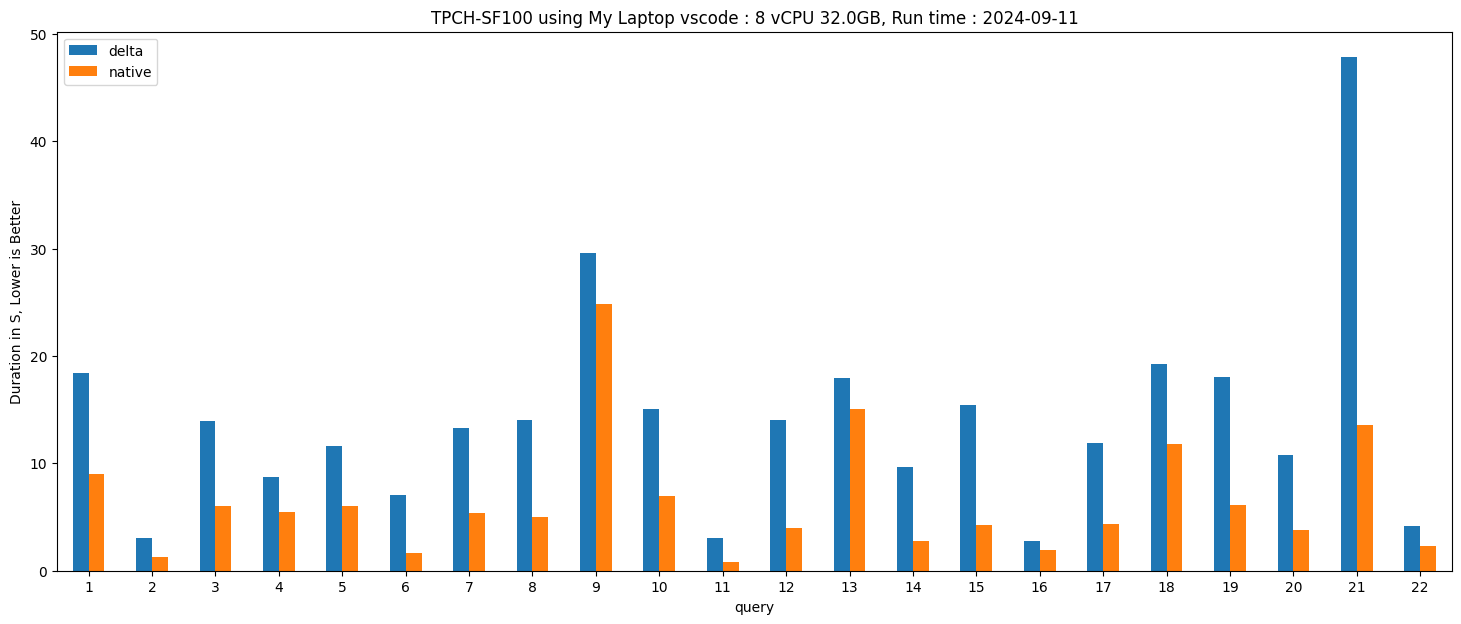

In [44]:
vCPU = str(cpu_count()) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)

result = duckdb.sql(f""" 
                    PIVOT(select Engine, dur, query from delta_scan('/lakehouse/default/Tables/dbo/result') where sf ={SF} 
                    and engine in ('native','delta'))
                    ON engine using avg(dur) order by Query
                    """).df()

runtime = 'TPCH-SF'+str(SF)+' using My Laptop vscode : '+vCPU+' '+str(mem)+'GB, Run time : '+ str(time.strftime("%Y-%m-%d")) 
ax = result.plot.bar(rot=0,title=runtime,x='query',ylabel='Duration in S, Lower is Better',figsize=(18,7))

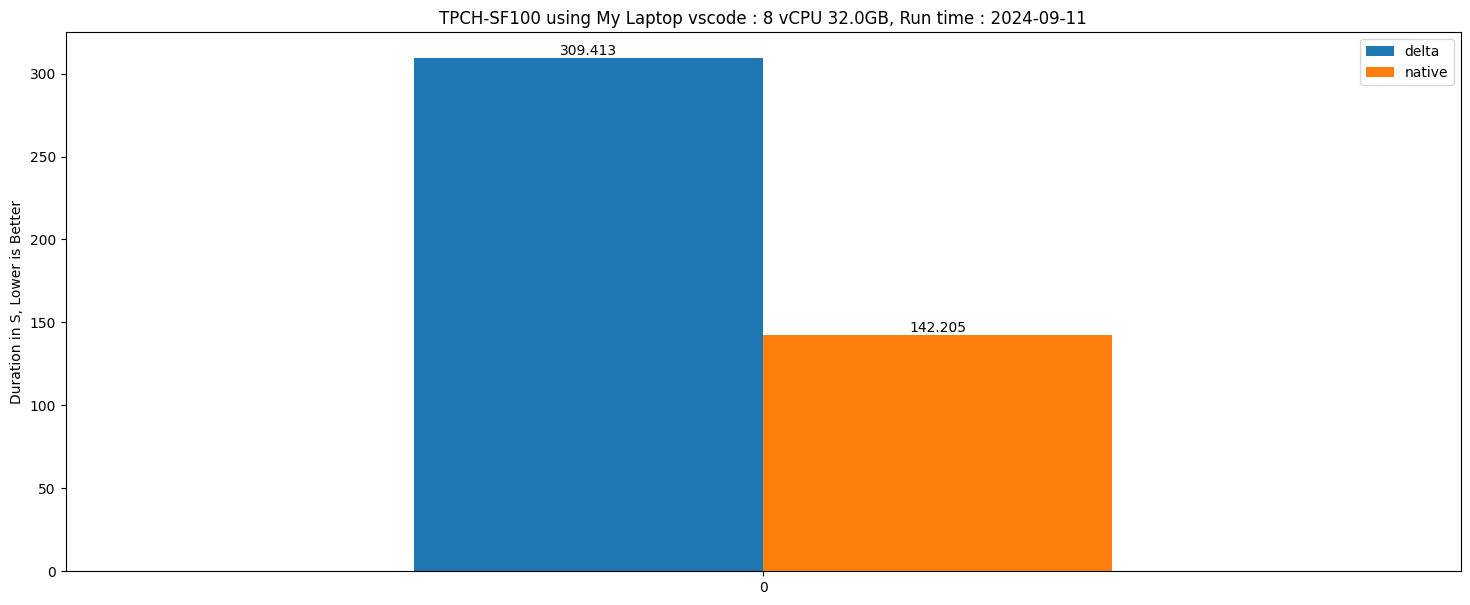

In [45]:
result = duckdb.sql(f"""   select sum(columns(*exclude(query))) from result """).df()
ax = result.plot.bar(rot=0,title=runtime,ylabel='Duration in S, Lower is Better',figsize=(18,7))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')